In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
import random
from numba import jit

继续关于用Monte Carlo模拟的方法来研究betting strategy的文章，这是第二篇，目标是实现Martingale策略并做一些分析。

这一篇的绝大部分工作同样来自于sendex发表在[油管上的视频](https://www.youtube.com/playlist?list=PLQVvvaa0QuDdhOnp-FnVStDsALpYk2hk0)，有科学上网条件的推荐看一下原版的视频。

---

**关于 Monte Carlo 方法在这个场景下应用意义的补充说明**

其实从上一篇应该就已经可以发现，对于简单的下注策略，其实比较容易就可以根据不超出高中数学的知识算出理论上的期望值。因此 Monte Carlo 模拟，从原则上来说，是不必要的，但从实际的角度，MC模拟主要的意义在于，当策略变复杂时，推算理论的期望值会变得很复杂，或者更准确地讲，很繁琐，MC模拟则提供了一种直观的结果。

---

摇骰子的功能不变。

In [2]:
def win_dice_python(n=49):
    roll = random.randint(1, 100)
    return bool(roll <= n)

@jit(nopython=True)
def win_dice(n=49):
    roll = random.randint(1, 100)
    return bool(roll <= n)

win_dice();  ## warming up the jitted function

In [3]:
wins = 0
losses = 0
for _ in range(1000000):
    if win_dice():
        wins += 1
    else:
        losses += 1
print('Win rate:', wins/1000000, '\tLoss rate:', losses/1000000)

Win rate: 0.48958 	Loss rate: 0.51042


这次的测试次数增加到了1e6，更加接近设定的49%胜率。

准备工作做完了。下面实现所谓的 Martingale 策略。

Martingale 策略，是一种相当激进的赌博策略，每赌输一次，就把赌注翻倍。如果本金一直足够，那么前面输了任意的 N 次，输掉的金额就是 $\sum_{i=1}^{N} 2^{i-1}$ 倍的初始赌注，如果下一次赢了，刚好会抵消前面输的所有钱，而且会赚回一倍的初始赌注。也就是说，如果满足如下两个条件：

1. 本金足够
2. 赢了一次就走

这个方法就是一个“稳赢”的策略。当然稍微动动脑子就知道，由于赌注是按指数增长的，条件一基本是不可能满足的。

接下来用模拟来看看究竟会怎么样。

In [4]:
@jit
def martingale_bettor(funds, init_wager, wager_count, plot=False):
    balance = funds
    wager = init_wager
    vY = -funds * np.ones(wager_count) / 10

    previous_wager = 'win'
    previous_wager_amount = init_wager
    for current_wager in range(wager_count):
        if previous_wager == 'win':
            if win_dice():
                balance += wager
                previous_wager = 'win'
            else:
                balance -= wager
                previous_wager = 'loss'
        else:
            wager = min(previous_wager_amount * 2, balance)
            if win_dice():
                balance += wager
                previous_wager = 'win'
                wager = init_wager
            else:
                balance -= wager
                previous_wager = 'loss'
        previous_wager_amount = wager
        vY[current_wager] = balance
        if balance <= 0:
            break
    if plot:
        plt.plot(vY, lw=0.5)
    return balance

逻辑也比较简单，需要注意的是第18行，下一次的赌注并不能简单地翻倍，因为下注的量不允许超过当前的现金量（不借钱的前提下）。如果看过 sentdex 的原始视频就会发现，他的资金曲线是几乎呈一条斜线上升的，只要没输光，所有的曲线几乎都重合，这也是上面理论分析的结果，但显然当亏到需要 all in 的时候，即使赢了也无法回到原来的线上，所以模拟的曲线会有不些不同。

跑个测试看一下是不是正确：

10400

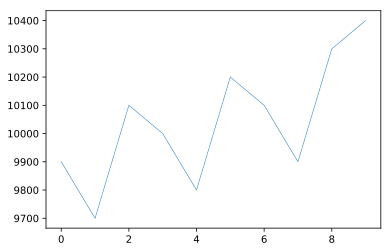

In [5]:
martingale_bettor(10000, 100, 10, plot=True)

上一篇中有一个忘记比较的东西是 Numba 的 JIT 究竟起了多大的作用，这里可以作一个对比：

In [6]:
def martingale_bettor_python(funds, init_wager, wager_count, plot=False):
    balance = funds
    wager = init_wager
    vY = -funds * np.ones(wager_count) / 10

    previous_wager = 'win'
    previous_wager_amount = init_wager
    for current_wager in range(wager_count):
        if previous_wager == 'win':
            if win_dice_python():
                balance += wager
                previous_wager = 'win'
            else:
                balance -= wager
                previous_wager = 'loss'
        else:
            wager = min(previous_wager_amount * 2, balance)
            if win_dice_python():
                balance += wager
                previous_wager = 'win'
                wager = init_wager
            else:
                balance -= wager
                previous_wager = 'loss'
        previous_wager_amount = wager
        vY[current_wager] = balance
        if balance <= 0:
            break
    if plot:
        plt.plot(vY, lw=0.5)
    return balance

%timeit martingale_bettor(1000, 10, 10)
%timeit martingale_bettor_python(1000, 10, 10)

The slowest run took 10997.41 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 51.2 µs per loop
10000 loops, best of 3: 54.8 µs per loop


看起来，在这里 JIT 只提高了 20% 左右的速度，比预想的低不少。尝试优化一下，打开 nopython 模式：

In [7]:
@jit(nopython=True)
def martingale_bettor2(funds, init_wager, wager_count):
    balance = funds
    wager = init_wager
    vY = -funds * np.ones(wager_count) / 10

    win_previous = True
    previous_wager_amount = init_wager
    for current_wager in range(wager_count):
        if win_previous:
            if win_dice():
                pass
                balance += wager
                win_previous = True
            else:
                balance -= wager
                win_previous = False
        else:
            wager = min(previous_wager_amount * 2, balance)
            if win_dice():
                balance += wager
                win_previous = True
                wager = init_wager
            else:
                balance -= wager
                win_previous = False
        previous_wager_amount = wager
        vY[current_wager] = balance
        if balance <= 0:
            break
    return balance

martingale_bettor2(1000, 10, 10)  # warming up
%timeit martingale_bettor2(1000, 10, 10)

The slowest run took 8.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 952 ns per loop


现在的结果看起来正常多了，大约快了五十多倍。很明显 JIT 效果不显著的原因在于函数中（不必要地）用到了对字符串的判断，改回单纯的 bool 类型后速度就正常了。现在跑一百万次的时间是：

In [8]:
%time for _ in range(1000000): martingale_bettor2(1000, 10, 10)

Wall time: 1.03 s


下面跑个100次看看资金量曲线是怎么变化的，有个感性的认识：

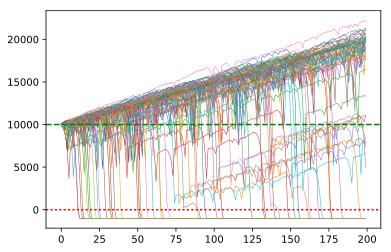

In [9]:
for _ in range(100):
    martingale_bettor(10000, 100, 200, plot=True)
plt.axhline(y=10000, ls='dashed', c='g')
plt.axhline(y=0, ls='dotted', c='r')

可以看到，Martingale 策略的结果相当极端，要么就直接亏到破产，要么就盈利。

那这个策略究竟是不是好策略呢？看看在初始赌注为总资金量一百分之一时，赌不同次数的收益情况：

In [10]:
wager_counts = [10, 20, 50, 100, 200, 500, 1000, 2000]
n_sim = 1000000
for wager_count in wager_counts:
    res = np.ones(n_sim, dtype='i8')
    for i in range(n_sim):
        balance = martingale_bettor2(10000, 100, wager_count)
        res[i] = balance
    print('Wager count is {}'.format(wager_count))
    print('Broke percentage: {:.1f}%'.format(len(res[res<=0])/n_sim * 100))
    print('Profit percentage: {:.1f}%'.format(len(res[res>10000])/n_sim * 100))
    print('If profit, average profit is: {:.1f}'.format(np.mean(res[res>10000]) - 10000))
    print('If nonprofit, average loss is: {:.1f}'.format(10000 - np.mean(res[res<=10000])))
    res[res<0] = 0
    print('In total, your expectation is: {:.1f}\n'.format(res.mean()))

Wager count is 10
Broke percentage: 2.2%
Profit percentage: 80.7%
If profit, average profit is: 465.7
If nonprofit, average loss is: 2228.7
In total, your expectation is: 9944.7

Wager count is 20
Broke percentage: 6.6%
Profit percentage: 80.9%
If profit, average profit is: 922.5
If nonprofit, average loss is: 4534.2
In total, your expectation is: 9877.9

Wager count is 50
Broke percentage: 18.6%
Profit percentage: 74.3%
If profit, average profit is: 2213.7
If nonprofit, average loss is: 7636.8
In total, your expectation is: 9682.8

Wager count is 100
Broke percentage: 31.4%
Profit percentage: 63.0%
If profit, average profit is: 4529.2
If nonprofit, average loss is: 9308.3
In total, your expectation is: 9416.1

Wager count is 200
Broke percentage: 48.9%
Profit percentage: 46.4%
If profit, average profit is: 8583.8
If nonprofit, average loss is: 9356.9
In total, your expectation is: 8970.3

Wager count is 500
Broke percentage: 72.9%
Profit percentage: 26.3%
If profit, average profit is:

> 关于性能的备注：如果对比过上面一段与前一篇类似的一类的速度，会发现尽管这里策略的逻辑更复杂，而且模拟的次数多了一个数量级，但总体花费的时间还是更少的，真正体现了 JIT 在大数据量时的优势。

在这里输出的结果中，我特地额外地输出了平均值，实际上也就是期望值，原因在于如果只看 profit rate 的话，结果是非常误导人的：在只下注20次的时候，盈利的比例居然达到了80%以上！！！但其实仔细看一眼，平均的盈利额是小于平均的亏损额的。也就是说，虽然有较高的概率获得盈利，但盈利时的收益小于亏损时的损失，平均来看，期望值是负的。

正好在不久之前看到一篇文章，在这个[知乎专栏](https://zhuanlan.zhihu.com/p/25198881)中讨论了投资中胜率与期望值的关系，得出的结论是稳定盈利的系统应该是每次盈利时的期望值高于亏损时的期望值，这样哪怕胜率低于50%，也完全有可能盈利。

倒回来看这里的结果，这个游戏原本的游戏规则是，玩家以49%的胜率且输赢的期望值相同进行赌博，庄家靠胜率上的优势赚钱（没有考虑手续费的问题），但采用 Martingale 策略（而且是较少的固定下注次数）则把这个游戏规则变成了看起来大胜率但期望仍然是负的，这种规则更适合**赌徒**，而且更具有迷惑性。

Martingale 现实中的一个操作方法是，设定一个初始的目标，然后达到目标后收手。这需要重新写下注的程序，额外接受一个盈利目标（初始赌注的倍数），并且在达到目标后就退出游戏。

In [11]:
@jit(nopython=True)
def martingale_win_and_leave(funds, init_wager, wager_count, target):
    balance = funds
    wager = init_wager
    vY = -funds * np.ones(wager_count) / 10

    win_previous = True
    previous_wager_amount = init_wager
    for i in range(wager_count):
        if win_previous:
            if win_dice():
                pass
                balance += wager
                win_previous = True
            else:
                balance -= wager
                win_previous = False
        else:
            wager = min(previous_wager_amount * 2, balance)
            if win_dice():
                balance += wager
                win_previous = True
                wager = init_wager
            else:
                balance -= wager
                win_previous = False
        previous_wager_amount = wager
        vY[i] = balance
        if balance <= 0:
            return -1, i+1
        elif balance >= funds + target * init_wager:
            return 1, i+1

    return 0, i+1

martingale_win_and_leave(10000, 100, 10000, 3)  # warming up

(1, 6)

返回了三种结果的状态和下注的次数，状态-1表示输光，0表示玩到最后没有达到目标也没有破产（可能性很小），1表示达到目标。模拟一下看看：

In [12]:
wins = 0
brokes = 0
n_sim = 100000

for _ in range(n_sim):
    stat, i = martingale_win_and_leave(100, 1, 10000, 5)
    if stat == -1:
        brokes += 1
    elif stat == 1:
        wins += 1
    else:
        print('You bet 10000 times and you don\'t go broke. What are the odds?!')
print('Win percentage is {:.2f}, broke percentage is {:.2f}'.format(wins/n_sim*100, brokes/n_sim*100))

Win percentage is 94.49, broke percentage is 5.51


这就很有意思了，大致的意思是，如果拿着一百块钱去赌，目标是赚5块钱，赚到就跑，那么有相当高的概率可以达到目标，但也有百分之五点多的概率会直接破产。

可以再进一步查看一下它的规律：

In [13]:
targets = [1, 5, 10, 20, 50, 100]
for target in targets:
    print('Target is {}:'.format(target))
    wins = 0
    brokes = 0
    n_sim = 100000
    n_bets = np.zeros(n_sim)

    for j in range(n_sim):
        stat, i = martingale_win_and_leave(100, 1, 10000, target)
        n_bets[j] = i
        if stat == -1:
            brokes += 1
        elif stat == 1:
            wins += 1
        else:
            print('You bet 10000 times and you don\'t go broke. What are the odds?!')
    print('Win percentage is {:.2f}, broke percentage is {:.2f}'.format(wins/n_sim*100, brokes/n_sim*100))
    print('If win, it takes {:.1f} bets in average.\n'.format(n_bets.mean()))

Target is 1:
Win percentage is 98.88, broke percentage is 1.12
If win, it takes 2.5 bets in average.

Target is 5:
Win percentage is 94.45, broke percentage is 5.55
If win, it takes 12.2 bets in average.

Target is 10:
Win percentage is 89.46, broke percentage is 10.54
If win, it takes 23.4 bets in average.

Target is 20:
Win percentage is 81.02, broke percentage is 18.98
If win, it takes 42.6 bets in average.

Target is 50:
Win percentage is 62.24, broke percentage is 37.76
If win, it takes 91.6 bets in average.

Target is 100:
Win percentage is 44.21, broke percentage is 55.79
If win, it takes 160.2 bets in average.



那么问题来了，你手上有100元，你愿意以62.24的概率去赚50元钱吗（小字附注：如果没赚到就会输光）？

看起来是个不错的主意（逃